# Denne kode indlæser en csv renser den, stemmer den, laver graf, tæller ord, og til sidst laver den det til en csv

## Vigtigt at bemærke ingen opdeling er sket inden det her så vi risikere leakage pt

### Jeg anbefaler at ændre csv navnet i bunden alt efter om det er træning, val eller test det bliver kørt på

In [2]:
#Jeg indlæser først modulerne
import re
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from cleantext import clean 
import matplotlib.pyplot as plt
from collections import Counter 
from pandarallel import pandarallel
import pandas as pd



In [59]:
#Læser data-filen
df = pd.DataFrame(pd.read_csv("val_set.csv")) #INDLÆS FIL HER

temp_df = df[["content","id"]].copy()

C:\Users\thran\AppData\Local\Temp\ipykernel_16160\1310260051.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.DataFrame(pd.read_csv("val_set.csv")) #INDLÆS FIL HER


### Tæller vocab før cleaning

In [ ]:
#Gør den raw dataframe 'content' til en string
uncleaned_string = '\n'.join(df["content"].astype(str))

#Gør 'uncleaned_string' til en liste
uncleaned_list=uncleaned_string.split() 

print("antal uncleaned words",len(set(uncleaned_list)))     #Gør listen til et set så gentagne elementer kun optræder 1 gang

antal uncleaned words 1372671


## OVERVEJ OM REMOVE_SPECIAL_CHARS SKAL I BRUG, DA no_punct=True IK ER OPTIMAL

In [ ]:
#Funktion der gør tekst til lower-case
def all_lower(x):
    x= x.lower()
    return x

#Funktion der fjerner tegn
def remove_special_chars(x):
    import re 
    return re.sub(r"[^a-zA-Z0-9<>]", " ", x)


#Funktion der erstatter datoer med <DATE>

def sub_dates(x):
    import re 
    sub_dates = re.sub(r'\d{4}[-/]\d{2}[-/]\d{2}|\d{2}[-/]\d{2}[-/]\d{4}', ' <DATE> ', x)
    sub_dates = re.sub(r'\b[a-z]+\s\d{1,2},\s\d{4}\b', '<DATE>', sub_dates)
    sub_dates = re.sub(r'\b\d{1,2}[,]?\s[a-zA-Z]+\s\d{4}\b', '<DATE>', sub_dates)
    return sub_dates



In [ ]:
# Initialiser pandarallel
pandarallel.initialize(progress_bar=True)  #giver os en progress
  # kan også manuelt indstilles

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


### Main cleaning function

In [ ]:
#Funktion til at cleane tekst
def autocleandf(x):
    from cleantext import clean 
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))

    x['content']=x['content'].astype(str).fillna("")

    x['content']=x['content'].parallel_apply(all_lower)

    x['content']=x['content'].parallel_apply(sub_dates)          #Applyer funktionen 'sub_dates' på 'content' kolonnen
    
    x['content']=x['content'].parallel_apply(                    #Applyer clean funktion fra modulet cleantext.
        lambda x: clean(str(x), lower=True, no_urls=True, no_emails=True, no_numbers=True, no_punct=True, no_currency_symbols=True))
    
    x['content']=x['content'].parallel_apply(lambda x: word_tokenize(str(x)))  #Applyer word_tokenize funktion fra nltk, som laver det til en liste af strings
    
    exclude_words = {"number", "date", "url", "email", "<", ">"}
    
    x['content'] = x['content'].parallel_apply(
    lambda x: [word for word in x if word not in exclude_words])
    
    x['content']=x['content'].parallel_apply(
        lambda x: [word for word in x if word not in stop_words])

autocleandf(temp_df)

### STEMMING

In [ ]:
from nltk.stem import PorterStemmer

def stemming(dataframe):
    ps = PorterStemmer()
    dataframe['content'] = dataframe['content'].parallel_apply(lambda x: " ".join(ps.stem(word) for word in x))

stemming(temp_df)


Mapper den midlertidige dataframe tilbage i den originale

In [ ]:
# Brug map til at opdatere content baseret på id
df['content'] = df['id'].map(temp_df.set_index('id')['content'])


In [ ]:
#Gør den raw dataframe 'content' til en string
cleaned_string = '\n'.join(df["content"].astype(str))

#Gør 'uncleaned_string' til en liste
cleaned_list=cleaned_string.split() 

print("cleaned vocabulary",len(set(cleaned_list)))     #Gør listen til et set så gentagne elementer kun optræder 1 gang

cleaned_antal_ord = Counter(cleaned_list)

#print("Total wordcount after cleaning:", len(cleaned_antal_ord))

prior = len(set(uncleaned_list))  # Antal unikke ord før rensning
after = len(set(cleaned_list))    # Antal unikke ord efter rensning
diff = prior - after              # Hvor mange ord er fjernet

print("Procentsvis ændring:", (diff / prior) * 100, "%")

cleaned vocabulary 434682
Procentsvis ændring: 68.33312570892807 %


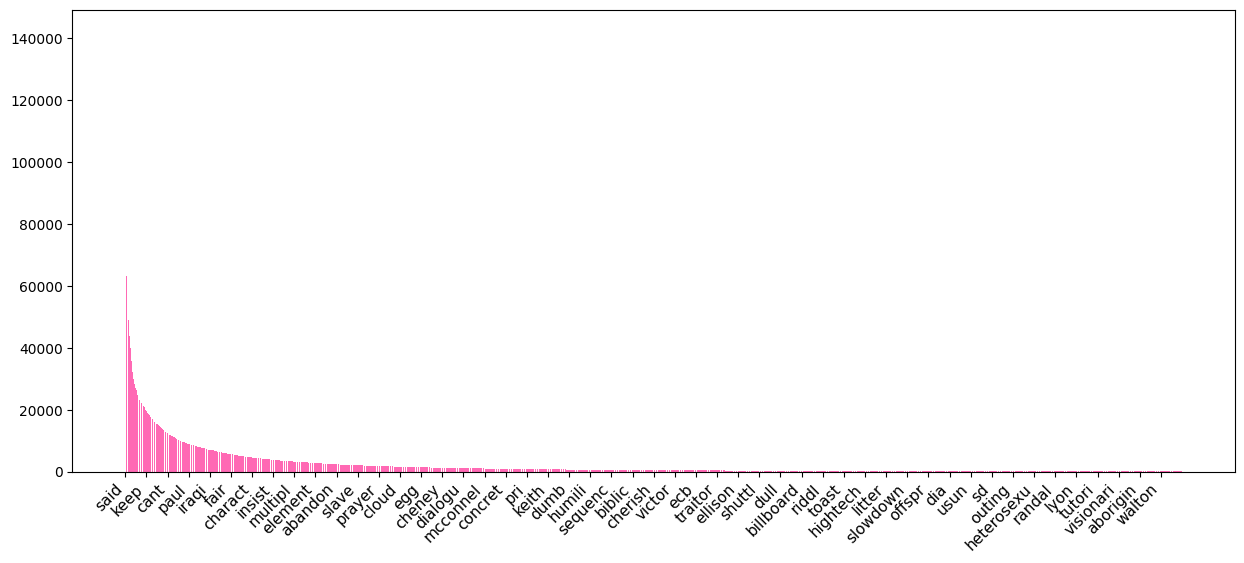

In [ ]:
hypiggeste_ord = cleaned_antal_ord.most_common(10000)   #De 10000 mest hyppige ord i 'ord_antal', laves til en liste mad tupler, 
                                                        #bestående af ord og ordet's hyppighed

ord = [ord for ord, tælling in hypiggeste_ord]          #Laver en liste med ordene fra 'hypiggeste_ord'. 
                                                        #Her itereres gennem hver tuple og udtrækkes ordet.
antal = [tælling for ord, tælling in hypiggeste_ord]    #Laver en liste med antal forekomster fra 'hypiggeste_ord'. 
                                                        #Her itereres gennem hver tuple og udtrækkes antal forekomster.
#Plottet
plt.figure(figsize=(15, 6))                             #Figurens højde og bredde
plt.bar(ord, antal, color = "hotpink")                  #'ord' og 'antal' sættes på x- og y-aksen i plottet
#plt.xticks(rotation=45, ha='right', fontsize=11)   
plt.xticks(range(0, len(ord), 200), ord[::200], rotation=45, ha='right', fontsize=11)
#Teksten på x-aksen roteres og tekststørrelsen vælges
plt.show() 

In [ ]:
# Brug map til at opdatere content baseret på id
df['content'] = df['id'].map(temp_df.set_index('id')['content'])

In [ ]:
category_mapping = {
    "fake": "Fake News",
    "satire": "Fake News",
    "bias": "Fake News",
    "conspiracy": "Fake News",
    "junksci": "Fake News",
    "hate": "Fake News",
    "clickbait": "Fake News",
    "unreliable": "Fake News",
    "political": "Reliable News",
    "reliable": "Reliable News" ,
    "Reliable News": "Reliable News"
}

# Apply the mapping
df['broad_category'] = df['type'].map(category_mapping)

# Check the result to make sure mapping is performed correctly
df[['broad_category', 'type']].head(10)

,broad_category,type
0,Fake News,unreliable
1,Reliable News,political
2,Fake News,fake
3,Fake News,bias
4,Fake News,bias
5,Fake News,fake
6,Reliable News,political
7,NaN,NaN
8,Reliable News,political
9,Fake News,bias


In [ ]:
df = df.dropna(subset=['broad_category'])


## Tjek herunder om alle kategorier bliver tildelt en broad-category

In [ ]:
df['type'].value_counts()

type
reliable      22041
political     19461
bias          13375
fake          10447
conspiracy     9702
unreliable     3472
clickbait      2683
junksci        1421
satire         1329
hate            887
Name: count, dtype: int64

In [ ]:
df.to_csv('cleanedStemmedCATbbc.csv')